In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set()

In [2]:
import sys
sys.path.append("../")
from src.data import read_files, collect_results, collect_predictions

## Important note

Protein sequence similarities must be computed before executing this notebook. To compute them, you need Biopython & EMBOSS. Once you installed requirements, you can run `python src/data/protein_similarity.py`

## Load filtered interactions

In [3]:
interaction_data = pd.read_csv('../data/BindingDB_filtered_gmean.csv', index_col=False)

C:\Users\gokce\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Load proteins and their annotations

In [4]:
similarity_matrix = pd.read_csv('../data/protein_similarities.csv', index_col=False)
similarity_matrix.rename(columns={'Unnamed: 0':'UniProt_S_ID'}, inplace=True)
protein_ids = similarity_matrix['UniProt_S_ID'].values.tolist()
sim_mat = similarity_matrix.to_numpy()
similarity_matrix = similarity_matrix.set_index('UniProt_S_ID')
sim_mat = sim_mat[:, 1:]
sim_mat.shape

(5469, 5469)

In [ ]:
from src.data import format_proteins
proteins = pd.read_csv('../data/BindingDB_1chain_proteins_all.csv', index_col=False)
proteins = format_proteins(proteins)
proteins.head()

..\tsdd\data\utils.py:76: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clans'] = df['clans'].str.replace('(nan, nan)', '"-", "-"')


In [ ]:
interaction_data_prot = interaction_data.merge(proteins, on=['UniProt_S_ID'], how='left')

We drop interactions whose protein family is unknown since we need Pfam family information to split proteins 

In [ ]:
interaction_data_known_prot = interaction_data_prot.dropna(axis=0, subset=['families'])
print('Interaction with unknown protein families', interaction_data_prot.shape[0] - interaction_data_known_prot.shape[0])

In [ ]:
interaction_data_known_prot_pos = interaction_data_known_prot[interaction_data_known_prot['gmean'] == 1]

In [ ]:
interaction_data_known_prot_neg = interaction_data_known_prot[interaction_data_known_prot['XC50'] > 10000]

In [ ]:
interaction_data_known_prot_pos.shape[0], interaction_data_known_prot_pos['UniProt_S_ID'].unique().shape[0], interaction_data_known_prot_pos['canonical_SMILES'].unique().shape[0],

In [ ]:
families = interaction_data_known_prot_pos['families_ids'].explode().reset_index(drop=True)
family_counts = families.value_counts().reset_index()

In [ ]:
family_counts[family_counts['families_ids'] > 100].rename(columns={'index': 'Pfam_id', 'families_ids': 'interaction_count'}).to_csv('../data/pfam_families.csv', index=False)

In [ ]:
family_counts[:40]

In [ ]:
family_interactions = interaction_data_known_prot_pos.explode('families_ids').reset_index(drop=True)

## Split dataset into train, val, test

We first select 10% proteins from each PFAM family to construct validation set and compute similarities of those proteins to the remaining proteins.

In [63]:
interaction_data_known_prot_neg.shape[0], interaction_data_known_prot_neg['UniProt_S_ID'].unique().shape[0], interaction_data_known_prot_neg['canonical_SMILES'].unique().shape[0],

(164696, 3817, 123763)

In [67]:
proteins_with_families = interaction_data_known_prot_pos[['families_ids', 'UniProt_S_ID']].explode(column='families_ids').reset_index(drop=True).drop_duplicates().rename(columns={'families_ids': 'Pfam'})

In [68]:
validation = proteins_with_families.groupby('Pfam').apply(lambda x: x.sample(frac=0.10)).rename(columns={'Pfam': 'Family_id'}).reset_index()
val_families_lst = validation['UniProt_S_ID'].values.tolist()

In [69]:
protein_with_families_wout_val = proteins_with_families[~proteins_with_families['UniProt_S_ID'].isin(val_families_lst)]
protein_with_families_wout_val.shape, validation.shape

((5014, 2), (417, 4))

In [70]:
print('Number of validation proteins without selection', len(val_families_lst))
print('Number of remaining proteins', protein_with_families_wout_val['UniProt_S_ID'].unique().shape[0])

Number of validation proteins without selection 417
Number of remaining proteins 2706


In [71]:
interaction_data_known_prot_pos['val'] = interaction_data_known_prot_pos['UniProt_S_ID'].apply(lambda x: x in val_families_lst)
print('Number of validation interactions', interaction_data_known_prot_pos[interaction_data_known_prot_pos['val']].shape[0])
print('Number of remaining interactions', interaction_data_known_prot_pos[interaction_data_known_prot_pos['val'] == False].shape[0])

C:\Users\gokce\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Number of validation interactions 74104
Number of remaining interactions 353963


In [72]:
val_proteins = interaction_data_known_prot_pos[interaction_data_known_prot_pos['val']]['UniProt_S_ID'].unique().tolist()
remaining_proteins = interaction_data_known_prot_pos[interaction_data_known_prot_pos['val'] == False]['UniProt_S_ID'].unique().tolist()

In [73]:
remaining_indices =  [protein_ids.index(protein) for protein in remaining_proteins]
val_indices =  [protein_ids.index(protein) for protein in val_proteins]

In [74]:
def compute_pairwise_similarity(protein_set1, protein_set2):
    set2_indices =  [protein_ids.index(protein) for protein in protein_set2]
    set1_indices =  [protein_ids.index(protein) for protein in protein_set1]
    set1_set2_similarities = {}
    set1_self_similarities = {}
    set2_self_similarities = {}
    for ix, index in enumerate(set1_indices):
        row = sim_mat[index, :] 
        col = sim_mat[:, index]
        set1_set2_similarities[protein_set1[ix]] = np.concatenate([row[set2_indices], col[set2_indices]])
        set1_self_similarities[protein_set1[ix]] = np.concatenate([row[set1_indices], col[set1_indices]])
    for ix, index in enumerate(set2_indices):
        row = sim_mat[index, :] 
        col = sim_mat[:, index]
        set2_self_similarities[protein_set2[ix]] = np.concatenate([row[set2_indices], col[set2_indices]])
        
    return set1_set2_similarities, set1_self_similarities, set2_self_similarities

In [75]:
val_remaining_sim, val_self_sim, remaining_self_sim = compute_pairwise_similarity(val_proteins, remaining_proteins)

C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

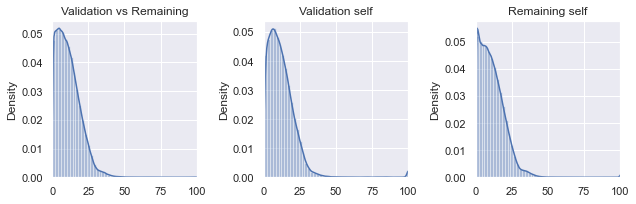

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
val_remain = np.concatenate(list(val_remaining_sim.values()))
sns.distplot( val_remain[val_remain != 0], ax=axes[0])
axes[0].set_title('Validation vs Remaining')
axes[0].set_xlim([0, 100])
val_self = np.concatenate(list(val_self_sim.values()))
sns.distplot(val_self[val_self != 0], ax=axes[1])
axes[1].set_title('Validation self')
axes[1].set_xlim([0, 100])
remaining_self = np.concatenate(list(remaining_self_sim.values()))
sns.distplot(remaining_self[remaining_self != 0], ax=axes[2])
axes[2].set_title('Remaining self')
axes[2].set_xlim([0, 100])
plt.tight_layout()

In [77]:
val_rem_sim_df = pd.DataFrame({'protein':val_remaining_sim.keys(), 'similarity': val_remaining_sim.values()})
val_rem_sim_df['max_similarity'] =  val_rem_sim_df['similarity'].apply(max)
val_rem_sim_df['max_similarity'].describe()

count    393.000000
mean      77.196438
std       21.176266
min       29.700000
25%       60.300000
50%       83.400000
75%       96.200000
max      100.000000
Name: max_similarity, dtype: float64

C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='max_similarity', ylabel='Density'>

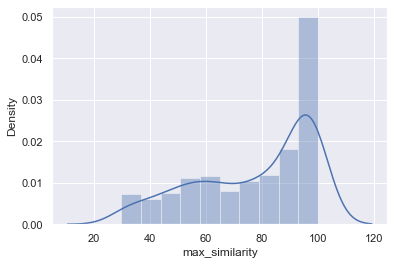

In [78]:
sns.distplot(val_rem_sim_df['max_similarity'], bins=10)

In [79]:
val_rem_sim_df.shape

(393, 3)

In [80]:
val_rem_sim_df.set_index('protein', inplace=True)

In [81]:
val_rem_sim_df_buckets = pd.cut(val_rem_sim_df['max_similarity'], bins=[i * 10 for i in range(11)]).reset_index()

In [82]:
val_rem_sim_df_buckets['max_similarity'].value_counts()

(90, 100]    169
(80, 90]      48
(60, 70]      43
(50, 60]      41
(70, 80]      35
(40, 50]      31
(30, 40]      24
(20, 30]       2
(0, 10]        0
(10, 20]       0
Name: max_similarity, dtype: int64

,index,max_similarity
0,"(50, 60]",37
1,"(80, 90]",36
2,"(60, 70]",34
3,"(70, 80]",33
4,"(40, 50]",30
5,"(30, 40]",24
6,"(90, 100]",4
7,"(20, 30]",2
8,"(0, 10]",0
9,"(10, 20]",0


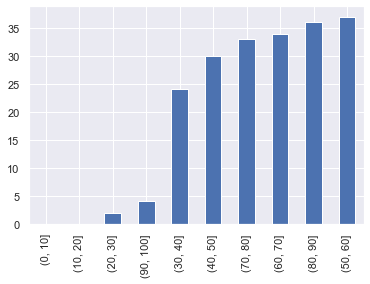

In [83]:
val_rem_sim_samples = val_rem_sim_df_buckets.sample(200, weights = 1/np.power(val_rem_sim_df_buckets.groupby('max_similarity')['max_similarity'].transform('count'), 3))
val_rem_sim_samples['max_similarity'].value_counts().sort_values('index').plot(kind='bar')
val_rem_sim_samples['max_similarity'].value_counts().reset_index()

In [84]:
val_rem_sim_samples['max_similarity'].describe()

count          200
unique           8
top       (50, 60]
freq            37
Name: max_similarity, dtype: object

C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


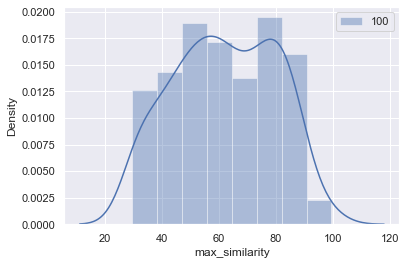

In [85]:
val_rem_sim_samples.shape[0]
val_rem_sim_df.reset_index(inplace=True)
val_rem_sim_samples_df = val_rem_sim_df[val_rem_sim_df.protein.isin(val_rem_sim_samples.protein)]
sns.distplot(val_rem_sim_samples_df['max_similarity'], label='100')
plt.legend()

In [86]:
val_rem_sim_samples_df

,protein,similarity,max_similarity
2,O00506,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",79.3
3,O00750,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",60.5
4,O02604,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",74.7
6,O09175,"[11.8, 8.1, 0.0, 13.5, 0.0, 0.0, 2.1, 0.0, 3.1...",51.3
7,O14920,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",67.1
...,...,...,...
386,Q9Y3Q4,"[7.6, 16.5, 5.8, 10.3, 0.0, 0.0, 6.0, 0.0, 19....",55.7
387,Q9Y4C1,"[0.0, 0.0, 0.0, 1.8, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30.6
388,Q9Y4K4,"[2.6, 6.2, 5.8, 13.7, 4.7, 0.0, 6.2, 3.0, 20.8...",68.8
390,Q9Y5X4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",47.4


In [87]:
#interaction_data_known_prot_pos.drop(['val_final'], axis=1, inplace=True)
interaction_data_known_prot_pos['val_final'] = interaction_data_known_prot_pos['UniProt_S_ID'].apply(lambda x: x in val_rem_sim_samples_df['protein'].values.tolist())

C:\Users\gokce\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
print('Number of validation interactions: ', interaction_data_known_prot_pos[interaction_data_known_prot_pos['val_final']].shape)
print('Number of validation proteins: ', interaction_data_known_prot_pos[interaction_data_known_prot_pos['val_final']]['UniProt_S_ID'].unique().shape[0])

Number of validation interactions:  (28403, 60)
Number of validation proteins:  200


In [89]:
print('Number of remaining interactions: ', interaction_data_known_prot_pos[interaction_data_known_prot_pos['val_final'] == False].shape)
print('Number of remaining proteins: ', interaction_data_known_prot_pos[interaction_data_known_prot_pos['val_final'] == False]['UniProt_S_ID'].unique().shape[0])

Number of remaining interactions:  (399664, 60)
Number of remaining proteins:  2899


In [90]:
#interaction_data_known_prot_pos = interaction_data_known_prot_pos.drop(['holdout'], axis=1)
holdout = protein_with_families_wout_val.groupby('Pfam').apply(lambda x: x.sample(frac=0.125)).rename(columns={'Pfam': 'Family_id'}).reset_index()
holdout_families_lst = holdout['UniProt_S_ID'].values.tolist()

In [91]:
protein_with_families_wout_val_holdout = protein_with_families_wout_val[~protein_with_families_wout_val['UniProt_S_ID'].isin(holdout_families_lst)]
protein_with_families_wout_val_holdout.shape, holdout.shape

((4163, 2), (396, 4))

In [92]:
print('Number of holdout proteins without selection', len(holdout_families_lst))
print('Number of remaining proteins', protein_with_families_wout_val_holdout['UniProt_S_ID'].unique().shape[0])

Number of holdout proteins without selection 396
Number of remaining proteins 2333


In [93]:
interaction_data_known_prot_pos['holdout'] = interaction_data_known_prot_pos['UniProt_S_ID'].apply(lambda x: x in holdout_families_lst)
print('Number of holdout interactions', interaction_data_known_prot_pos[interaction_data_known_prot_pos['holdout']].shape[0])
print('Number of remaining interactions', interaction_data_known_prot_pos[interaction_data_known_prot_pos['holdout'] == False].shape[0])

C:\Users\gokce\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Number of holdout interactions 67577
Number of remaining interactions 360490


In [94]:
holdout_proteins = interaction_data_known_prot_pos[interaction_data_known_prot_pos['holdout']]['UniProt_S_ID'].unique().tolist()
train_proteins = interaction_data_known_prot_pos[(interaction_data_known_prot_pos['holdout'] == False) & (interaction_data_known_prot_pos['val'] == False)]['UniProt_S_ID'].unique().tolist()

In [97]:
#protein_ids = similarity_matrix['UniProt_S_ID'].values.tolist()
train_indices =  [protein_ids.index(protein) for protein in train_proteins]
holdout_indices =  [protein_ids.index(protein) for protein in holdout_proteins]

In [98]:
holdout_train_sim, holdout_self_sim, train_self_sim = compute_pairwise_similarity(holdout_proteins, train_proteins)

C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

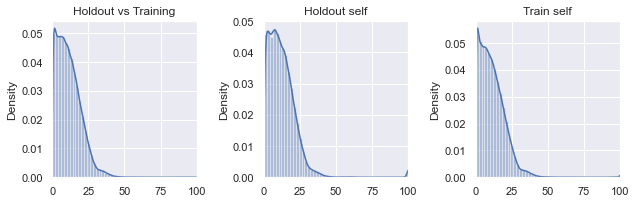

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
holdout_train = np.concatenate(list(holdout_train_sim.values()))
sns.distplot( holdout_train[holdout_train != 0], ax=axes[0])
axes[0].set_title('Holdout vs Training')
axes[0].set_xlim([0, 100])
holdout_self = np.concatenate(list(holdout_self_sim.values()))
sns.distplot(holdout_self[holdout_self != 0], ax=axes[1])
axes[1].set_title('Holdout self')
axes[1].set_xlim([0, 100])
train_self = np.concatenate(list(train_self_sim.values()))
sns.distplot(train_self[train_self != 0], ax=axes[2])
axes[2].set_title('Train self')
axes[2].set_xlim([0, 100])
plt.tight_layout()

In [100]:
holdout_train_sim_df = pd.DataFrame({'protein':holdout_train_sim.keys(), 'similarity': holdout_train_sim.values()})
holdout_train_sim_df['max_similarity'] =  holdout_train_sim_df['similarity'].apply(max)
holdout_train_sim_df['max_similarity'].describe()

count    373.000000
mean      72.981501
std       23.350431
min       24.900000
25%       52.200000
50%       80.400000
75%       94.700000
max      100.000000
Name: max_similarity, dtype: float64

C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='max_similarity', ylabel='Density'>

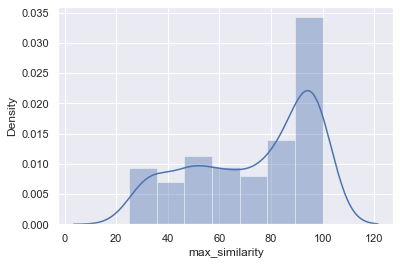

In [101]:
sns.distplot(holdout_train_sim_df['max_similarity'])

In [102]:
holdout_train_sim_df.set_index('protein', inplace=True)

In [103]:
holdout_train_sim_df_buckets = pd.cut(holdout_train_sim_df['max_similarity'], bins=[i * 10 for i in range(11)]).reset_index()

In [104]:
holdout_train_sim_df_buckets['max_similarity'].value_counts()

(90, 100]    133
(80, 90]      56
(30, 40]      39
(60, 70]      37
(40, 50]      33
(50, 60]      33
(70, 80]      29
(20, 30]      13
(0, 10]        0
(10, 20]       0
Name: max_similarity, dtype: int64

,index,max_similarity
0,"(60, 70]",34
1,"(50, 60]",33
2,"(40, 50]",31
3,"(30, 40]",29
4,"(70, 80]",29
5,"(80, 90]",25
6,"(20, 30]",13
7,"(90, 100]",6
8,"(0, 10]",0
9,"(10, 20]",0


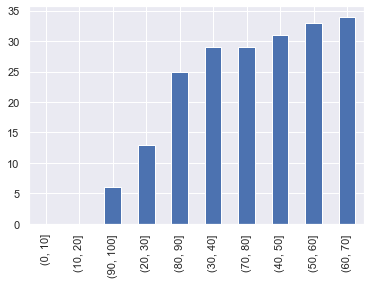

In [105]:
holdout_train_sim_samples = holdout_train_sim_df_buckets.sample(200, weights = 1/np.power(holdout_train_sim_df_buckets.groupby('max_similarity')['max_similarity'].transform('count'), 3))
holdout_train_sim_samples['max_similarity'].value_counts().sort_values('index').plot(kind='bar')
holdout_train_sim_samples['max_similarity'].value_counts().reset_index()

In [106]:
holdout_train_sim_samples['max_similarity'].describe()

count          200
unique           8
top       (60, 70]
freq            34
Name: max_similarity, dtype: object

C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


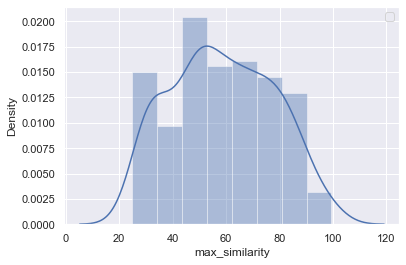

In [107]:
holdout_train_sim_df.reset_index(inplace=True)
holdout_train_sim_samples_df = holdout_train_sim_df[holdout_train_sim_df.protein.isin(holdout_train_sim_samples.protein)]
sns.distplot(holdout_train_sim_samples_df['max_similarity'])
plt.legend()

In [108]:
interaction_data_known_prot_pos['holdout_final'] = interaction_data_known_prot_pos['UniProt_S_ID'].apply(lambda x: x in holdout_train_sim_samples_df['protein'].values.tolist())

C:\Users\gokce\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
print('Number of holdout interactions: ', interaction_data_known_prot_pos[interaction_data_known_prot_pos['holdout_final']].shape)
print('Number of holdout proteins: ', interaction_data_known_prot_pos[interaction_data_known_prot_pos['holdout_final']]['UniProt_S_ID'].unique().shape[0])

Number of holdout interactions:  (26321, 62)
Number of holdout proteins:  200


In [110]:
print('Number of remaining interactions: ', interaction_data_known_prot_pos[(interaction_data_known_prot_pos['holdout'] == False) & (interaction_data_known_prot_pos['val'] == False)].shape)
print('Number of remaining proteins: ', interaction_data_known_prot_pos[(interaction_data_known_prot_pos['holdout'] == False) & (interaction_data_known_prot_pos['val'] == False)]['UniProt_S_ID'].unique().shape[0])

Number of remaining interactions:  (286386, 62)
Number of remaining proteins:  2333


In [111]:
train_interactions = interaction_data_known_prot_pos[(interaction_data_known_prot_pos['holdout'] == False) & (interaction_data_known_prot_pos['val'] == False)]
val_interactions = interaction_data_known_prot_pos[interaction_data_known_prot_pos['val_final']]
holdout_interactions = interaction_data_known_prot_pos[interaction_data_known_prot_pos['holdout_final']]

In [112]:
train_proteins = train_interactions['UniProt_S_ID'].unique().tolist()
val_proteins = val_interactions['UniProt_S_ID'].unique().tolist()
holdout_proteins = holdout_interactions['UniProt_S_ID'].unique().tolist()

In [113]:
interaction_data_known_prot_pos[interaction_data_known_prot_pos['UniProt_S_ID'].isin(holdout_proteins)]['target_organism'].value_counts().reset_index()

,index,target_organism
0,Homo sapiens,19420
1,Rattus norvegicus,539
2,Mus musculus,261
3,Rattus,167
4,Mycobacterium tuberculosis,157
5,Staphylococcus aureus,67
6,Oryctolagus cuniculus,61
7,Escherichia coli,12
8,Zea mays,11
9,Plasmodium falciparum,10


In [114]:
holdout_train_sim, holdout_self_sim, train_self_sim = compute_pairwise_similarity(holdout_proteins, train_proteins)

In [115]:
val_train_sim, val_self_sim, _ = compute_pairwise_similarity(val_proteins, train_proteins)

In [116]:
val_holdout_sim, _, _ = compute_pairwise_similarity(val_proteins, holdout_proteins)

In [117]:
holdout_train = np.concatenate(list(holdout_train_sim.values()))
holdout_train = holdout_train[holdout_train != 0]
val_train = np.concatenate(list(val_train_sim.values()))
val_train = val_train[val_train != 0]
val_holdout = np.concatenate(list(val_holdout_sim.values()))
val_holdout = val_holdout[val_holdout != 0]
train_self = np.concatenate(list(train_self_sim.values()))
train_self = train_self[train_self != 0]
val_self = np.concatenate(list(val_self_sim.values()))
val_self = val_self[val_self != 0]
holdout_self = np.concatenate(list(holdout_self_sim.values()))
holdout_self = holdout_self[holdout_self != 0]

C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gokce\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

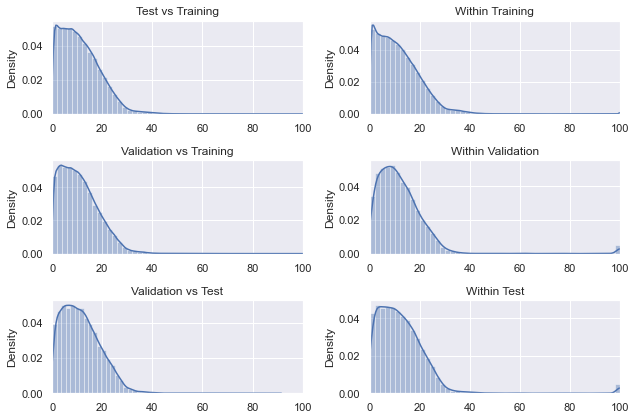

In [118]:
fig, axes = plt.subplots(3, 2, figsize=(9, 6))
sns.distplot(holdout_train, ax=axes[0][0])
axes[0][0].set_title('Test vs Training')
axes[0][0].set_xlim([0, 100])

sns.distplot(val_train, ax=axes[1][0])
axes[1][0].set_title('Validation vs Training')
axes[1][0].set_xlim([0, 100])

sns.distplot(val_holdout, ax=axes[2][0])
axes[2][0].set_title('Validation vs Test')
axes[2][0].set_xlim([0, 100])

sns.distplot(train_self, ax=axes[0][1])
axes[0][1].set_title('Within Training')
axes[0][1].set_xlim([0, 100])

sns.distplot(val_self, ax=axes[1][1])
axes[1][1].set_title('Within Validation')
axes[1][1].set_xlim([0, 100])

sns.distplot(holdout_self, ax=axes[2][1])
axes[2][1].set_title('Within Test')
axes[2][1].set_xlim([0, 100])
plt.tight_layout()
# plt.savefig('../figures/seq_similarities.pdf')

In [119]:
train_interactions.shape[0], train_interactions['UniProt_S_ID'].unique().shape[0], train_interactions['canonical_SMILES'].unique().shape[0]

(286386, 2333, 235779)

In [120]:
val_interactions.shape[0], val_interactions['UniProt_S_ID'].unique().shape[0], val_interactions['canonical_SMILES'].unique().shape[0]

(28403, 200, 26317)

In [121]:
holdout_interactions.shape[0], holdout_interactions['UniProt_S_ID'].unique().shape[0], holdout_interactions['canonical_SMILES'].unique().shape[0]

(26321, 200, 25557)

In [4]:
from rdkit import Chem
def standardise(smiles, canonicalise=True):
    """
    Standardise a SMILES string if valid (canonical + kekulized)
    Args:
        smiles: SMILES string
        canonicalise: optional flag to override `self.canonicalise`
    Returns: standard version the SMILES if valid, None otherwise

    https://github.com/BenevolentAI/MolBERT/blob/main/molbert/utils/featurizer/molfeaturizer.py
    """
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
    except Exception as e:
        # invalid?
        logging.warning(f'Chem.MolFromSmiles failed smiles="{smiles}" error={e}')
        return None

    if mol is None:
        # invalid?
        logging.warning(f'Chem.MolFromSmiles failed smiles="{smiles}"')
        return None

    flags = Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_CLEANUP
    Chem.SanitizeMol(mol, flags, catchErrors=True)

    if canonicalise:
        # bug where permuted smiles are not canonicalised to the same form. This is fixed by round tripping SMILES
        mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
        if mol is None:
            logging.warning(f'Chem.MolFromSmiles failed after sanitization smiles="{smiles}"')
            return None

#    try:
#         Chem.Kekulize(mol, clearAromaticFlags=True)
#         smiles = Chem.MolToSmiles(mol, kekuleSmiles=True, canonical=canonicalise)      
#     except (ValueError, RuntimeError):
#         logging.warning(f'SMILES failed Kekulization! {smiles}')
#         return None

    return smiles

standardise('C1=C(Cl)C(Cl)=CC=C1')

'C1=C(Cl)C(Cl)=CC=C1'

In [124]:
train_interactions['canonical_SMILES'] = train_interactions['SMILES'].apply(standardise)
val_interactions['canonical_SMILES'] = val_interactions['SMILES'].apply(standardise)
holdout_interactions['canonical_SMILES'] = holdout_interactions['SMILES'].apply(standardise)

C:\Users\gokce\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\gokce\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gokce\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [ ]:
from pathlib import Path
path = Path('../data/splits')
path.mkdir(parents=True, exist_ok=True)
train_interactions[['UniProt_S_ID', 'canonical_SMILES', 'BindingDB_ID', 'SMILES', 'PubChem_CID', 'target_sequence']].to_csv(path / 'train_interactions.csv', index=False)
val_interactions[['UniProt_S_ID', 'canonical_SMILES', 'BindingDB_ID', 'SMILES', 'PubChem_CID', 'target_sequence']].to_csv(path / 'val_interactions.csv', index=False)
holdout_interactions[['UniProt_S_ID', 'canonical_SMILES', 'BindingDB_ID', 'SMILES', 'PubChem_CID', 'target_sequence']].to_csv(path / 'test_interactions.csv', index=False)